## Indirect inference of life-cycle consumption/saving models with arbitrary expectations

- author: Tao Wang
- this is a derivative notebook from the paper ["Perceived income risks"](https://github.com/iworld1991/PIR/blob/master/PIR.pdf)

This notebook includes the code that estimates preference parameters based on simulated stationary distributions of households by mactching chosen moments of the model and data, including but not limiting to  
   - mean/median wealth to (permanent) income ratio
   - lorenz curve (wealth quantiles)
   - life cycle wealth profile
   - life cycle consumption profiles
   - ...
      
The general structure of the code is the following 
   - __solve_and_simulate__, a wrapper function that takes the household block as input and then spit out the model solutions and simulated moments stored in a dictionary;
   - __model_data_diff__, a general function that takes a household model type, data moments and moment choices, and generate moments distance between model and data ;
   - objective function specific to the parameters to be estimated;
   - a general estimtor function that allows users to choose consumer model, data moments and parameters to estimate. 
  
A few additional features:
   - the model implied moments could include cross-sectional distribution of income expectations/income risks and expected consumption growth.
   - more importantly, the covariance of the two.  

In [1]:
from psutil import Process 

In [2]:
import numpy as np
import pandas as pd
from interpolation import interp, mlinterp
from numba import njit
from numba.typed import List
import matplotlib as mp
import matplotlib.pyplot as plt
from time import time
from Utility import make_grid_exp_mult
import scipy.optimize as op
from matplotlib import cm
import joypy
from copy import copy
from Utility import cal_ss_2markov,lorenz_curve, gini,h2m_ratio,wealth_share
from Utility import mean_preserving_spread
from Utility import jump_to_grid,jump_to_grid_fast,gen_tran_matrix,gen_tran_matrix_fast
from Utility import stationary_age_dist
import pickle
from scipy import sparse 

## for estimation 
from scipy.optimize import minimize


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
## figure plotting configurations

plt.style.use('seaborn-v0_8')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

### The Life-cycle Model Class and the Solver

In [4]:
from SolveLifeCycle import LifeCycle, solve_model_backward_iter

## LifeCycle is a class for solving life-cycle consumption/saving problems 

### Initialize the model

In [5]:
from PrepareParameters import life_cycle_paras_q as lc_paras_Q
from PrepareParameters import life_cycle_paras_y as lc_paras_Y
## make a copy of the imported parameters 
lc_paras_y = copy(lc_paras_Y)
lc_paras_q = copy(lc_paras_Q)

In [6]:
print(lc_paras_y)

{'ρ': 2.0, 'β': 0.97, 'P': array([[0.18, 0.82],
       [0.04, 0.96]]), 'z_val': array([0., 1.]), 'σ_ψ': 0.15, 'σ_θ': 0.15, 'U': 0.0, 'LivPrb': array([0.9988675, 0.9988325, 0.9987925, 0.9987475, 0.9987015, 0.998656 ,
       0.9986075, 0.998557 , 0.9985025, 0.9984395, 0.9983705, 0.9983025,
       0.9982365, 0.9981685, 0.9980885, 0.9979895, 0.99787  , 0.9977265,
       0.997558 , 0.997369 , 0.9971545, 0.9969015, 0.9966045, 0.996268 ,
       0.9959   , 0.9955075, 0.9950905, 0.9946495, 0.994184 , 0.993683 ,
       0.9931515, 0.9926035, 0.992042 , 0.99146  , 0.9908095, 0.990104 ,
       0.9894025, 0.988719 , 0.988012 , 0.9872155, 0.9862755, 0.985182 ,
       0.983905 , 0.9824375, 0.9807325, 0.978823 , 0.976777 , 0.9746125,
       0.9722515, 0.969501 , 0.966323 , 0.9628335, 0.9590265, 0.95479  ,
       0.9498745, 0.9442255, 0.93797  , 0.93109  , 0.9234355, 0.914817 ]), 'n': 0.005, 'R': 1.01, 'W': 1.0, 'T': 40, 'L': 60, 'G': array([1.02716959, 1.02550316, 1.02387214, 1.022277  , 1.02071857,
  

### Initialize a consuption/saving model

In [7]:
## initialize a class of life-cycle model with either calibrated or test parameters 

#################################
calibrated_model = True
model_frequency = 'yearly'
#################################

if calibrated_model == True:

    if model_frequency=='yearly':
        ## yearly parameters 

        lc_paras = lc_paras_y

    elif model_frequency=='quarterly':
        lc_paras = lc_paras_q

    lc_mkv_paras = { 
        ## primitives
                   'ρ':lc_paras['ρ'],     ## relative risk aversion  
                   'β':lc_paras['β'],     ## discount factor
                   'borrowing_cstr':True,
                   'adjust_prob':1.0,
        
        ## prices 
                   'R':lc_paras['R'],           ## interest factor
                   'W':lc_paras['W'],           ## Wage rate
        
        ## life cycle 
                   'T':lc_paras['T'],
                   'L':lc_paras['L'],
                   'G':lc_paras['G'],
                   'LivPrb':lc_paras['LivPrb'],       ## living probability 
        
        ## income risks 
                   'x':0.0,
                   'b_y':0.0,
                   'sigma_psi':lc_paras['σ_ψ'],
                   'sigma_eps':lc_paras['σ_θ'],
                   'ue_markov':True,
                   'P':lc_paras['P'],
                   'U':lc_paras['U'],
                   'z_val':lc_paras['z_val'], ## markov state from low to high 
                   'sigma_psi_2mkv':lc_paras['σ_ψ_2mkv'],  ## permanent risks in 2 markov states
                   'sigma_eps_2mkv':lc_paras['σ_θ_2mkv'],  ## transitory risks in 2 markov states
                   'sigma_psi_true':lc_paras['σ_ψ'], ## true permanent
                   'sigma_eps_true':lc_paras['σ_θ'], ## true transitory
        
        ## initial conditions 
                    'sigma_p_init':lc_paras['σ_ψ_init'],
                    'init_b':lc_paras['init_b'],
        
         ## bequest motives
        ######################
                   'q': 1.0,
                   'ρ_b':lc_paras['ρ'], ## homothetic bequest motive
        #######################

        ## policy 
                   'unemp_insurance':lc_paras['unemp_insurance'],
                   'pension':lc_paras['pension'], ## pension
                   'λ':lc_paras['λ'],  ## tax rate
                   'λ_SS':lc_paras['λ_SS'], ## social tax rate
                   'transfer':lc_paras['transfer'],  ## transfer 
                   'bequest_ratio':lc_paras['bequest_ratio'],
        
         ## solutions 
                   'shock_draw_size':10.0,
                   'grid_max':10}
    
    ## initialize the model with calibrated parameters 
    
    lc_mkv = LifeCycle(**lc_mkv_paras)    
    

In [8]:
#################################
## general functions used 
# for computing transition matrix
##################################

## compute the list of transition matrix from age t to t+1 for all age 

@njit
def calc_transition_matrix(model, 
                           ms_star, ## new,  life cycle age x asset x tran shock x z state grid 
                           σs_star, ## new, life cycle consumption t age  x asset x tran shock x z state grid
                           dist_mGrid_list, ## new, list, grid of m for distribution 
                           dist_pGrid_list,  ## new, list, grid of p for distribution 
                           fast = False   ## new
                          ):
        '''
        Calculates how the distribution of agents across market resources 
        transitions from one period to the next. 
        If finite horizon problem, then calculates
        a list of transition matrices, consumption and asset policy grids for each period of the problem. 
        
        
        Parameters
        ----------
            # ms_star: array, sized of T x n_a x n_eps x n_z, wealth grid 
            # σs_star: array, sized of T x n_a x n_eps x n_z, consumption values at the grid
            # dist_mGrid_list, list, sized of 1, list of m grid sized of n_m
            # dist_pGrid_list, list, sized of T, list of permanent income grid for each age, sized of n_p
            # fast, bool, fast or slow method 

        Returns
        -------
            # tran_matrix_list, numba typed list, embedded list, sized of n_z,
            ## each of which is sized of T, each of which is sized of n_m x n_p 
        
        ''' 

        ## unemployment insurance 
        unemp_insurance = model.unemp_insurance
        
        ## tax rate
        λ = model.λ
        λ_SS = model.λ_SS
        
        ## permanent income growth factor
        G = model.G
        
        ## grid holders
 
        aPol_Grid_e_list = [] # List of asset policy grids for each period in T_cycle
        aPol_Grid_u_list = [] # List of asset policy grids for each period in T_cycle
        
        
        tran_matrix_e_list = [] # List of transition matrices
        tran_matrix_u_list = [] # List of transition matrices
        

        #Obtain shocks and shock probabilities from income distribution in this period
        size_shk_probs  = len(model.eps_shk_true_draws)*len(model.psi_shk_true_draws)
        shk_prbs = np.ones(size_shk_probs)*1/size_shk_probs
        tran_shks = np.exp(np.repeat(model.eps_shk_true_draws,
                              len(model.psi_shk_true_draws)))
        perm_shks = np.exp(np.repeat(model.psi_shk_true_draws,
                              len(model.eps_shk_true_draws)))

        ## This is for the fast method 
        shk_prbs_ntrl =  np.multiply(shk_prbs,perm_shks)
                        
                         
        for k in range(model.L): ## loop over agents at different ages, k
            
            age_id = k
            age = age_id + 1
            year_left = model.L-age
            
            markov_array2 = model.P

            this_dist_pGrid = dist_pGrid_list[0] #If here then use prespecified permanent income grid
            ## m-grid does not depend on period             
            this_dist_mGrid = dist_mGrid_list[0]
        
            
            ## compute different c at different a and eps
            
            n_mgrid = len(this_dist_mGrid)
            
            Cnow_u= np.empty(n_mgrid,dtype = np.float64)
            Cnow_e = np.empty(n_mgrid,dtype = np.float64)

            fix_epsGrid = 1.0 ## can be anything because c is not a function of eps
            
            for m_id,m in enumerate(this_dist_mGrid):
                Cnow_u[m_id] = mlinterp((ms_star[year_left,:,0,0],   
                                        model.eps_grid),
                                       σs_star[year_left,:,:,0],
                                       (m,fix_epsGrid))
                
                Cnow_e[m_id] = mlinterp((ms_star[year_left,:,0,1],
                                        model.eps_grid),
                                       σs_star[year_left,:,:,1],
                                       (m,fix_epsGrid))
                
            
            ## more generally, depending on the nb of markov states 
        
            aNext_u = this_dist_mGrid - Cnow_u # Asset policy grid in each age
            aNext_e = this_dist_mGrid - Cnow_e # Asset policy grid in each age
            
            aPol_Grid_u_list.append(aNext_u) # Add to list
            aPol_Grid_e_list.append(aNext_e) # Add to list

            bNext_u = model.R*aNext_u
            bNext_e = model.R*aNext_e

            
            ## determine income process depending on emp/uemp| work/retirement
            if k <=model.T-1:
                ## work age 
                perm_shks_G_ef = perm_shks* G[k+1]
                tran_shks_ef_u = np.ones_like(tran_shks)*(model.transfer
                                                        +(1-λ)*unemp_insurance)
                tran_shks_ef_e = np.ones_like(tran_shks)*(model.transfer
                                                        +(1-λ)*(1-λ_SS)*tran_shks)

                #mNext_ij = bNext_u[i]/perm_shks_G +model.transfer+ (1-λ)*unemp_insurance # Compute next period's market resources given todays bank balances bnext[i]
            else:
                ## retirement
                perm_shks_G_ef = np.ones_like(perm_shks)*G[k+1]
                tran_shks_ef_u = np.ones_like(tran_shks)*(model.transfer
                                                        + model.pension)
                tran_shks_ef_e = tran_shks_ef_u

            if fast==True:
                print('warning: the fast method is not fully developed yet!!!')
            
                # Generate Transition Matrix for u2u
                TranMatrix_uu = gen_tran_matrix_fast(this_dist_mGrid, 
                                                     bNext_u, 
                                                     shk_prbs_ntrl,
                                                     perm_shks_G_ef,
                                                     tran_shks_ef_u)
                
                # Generate Transition Matrix for u2e
                TranMatrix_ue = gen_tran_matrix_fast(this_dist_mGrid, 
                                                     bNext_e, 
                                                     shk_prbs_ntrl,
                                                     perm_shks_G_ef,
                                                     tran_shks_ef_e)
            

                # Generate Transition Matrix for e2e 
                
                TranMatrix_ee = gen_tran_matrix_fast(this_dist_mGrid, 
                                                     bNext_e, 
                                                     shk_prbs_ntrl,
                                                     perm_shks_G_ef,
                                                     tran_shks_ef_e)
            

                # Generate Transition Matrix for e2u 
                 
                TranMatrix_eu = gen_tran_matrix_fast(this_dist_mGrid, 
                                                     bNext_u, 
                                                     shk_prbs_ntrl,
                                                     perm_shks_G_ef,
                                                     tran_shks_ef_u)


            else:  ## slow method  (2-state Markov implemented)

                    
                # Generate Transition Matrix for u2u 
                TranMatrix_uu = gen_tran_matrix(this_dist_mGrid,
                                               this_dist_pGrid,
                                               bNext_u,
                                               shk_prbs,
                                               perm_shks_G_ef,
                                               tran_shks_ef_u)
                
    
                # Generate Transition Matrix for u2e
                
                TranMatrix_ue = gen_tran_matrix(this_dist_mGrid,
                                               this_dist_pGrid,
                                               bNext_u,
                                               shk_prbs,
                                               perm_shks_G_ef,
                                               tran_shks_ef_e)

                        
                # Generate Transition Matrix for e2u 
                
                TranMatrix_eu = gen_tran_matrix(this_dist_mGrid,
                                               this_dist_pGrid,
                                                bNext_e,
                                               shk_prbs,
                                               perm_shks_G_ef,
                                               tran_shks_ef_u)
                        
                # Generate Transition Matrix for e2e 
                TranMatrix_ee = gen_tran_matrix(this_dist_mGrid,
                                               this_dist_pGrid,
                                               bNext_e,
                                               shk_prbs,
                                               perm_shks_G_ef,
                                               tran_shks_ef_e)
                        
        ###################################################
        ## back from the fork between slow and fast method 
        ##################################################
        ## transition matrix for each markov state 
            tran_matrix_u = markov_array2[0,1] * TranMatrix_ue  + markov_array2[0,0]* TranMatrix_uu #This is the transition for someone who's state today is unemployed
            tran_matrix_e = markov_array2[1,1]*TranMatrix_ee  +  markov_array2[1,0] * TranMatrix_eu # This is the transition for someone who's state is employed today

                
            ## merge to the life cycle list 
            tran_matrix_u_list.append( tran_matrix_u ) #This is the transition for someone who's state today is unemployed
            tran_matrix_e_list.append( tran_matrix_e )
            
                
        tran_matrix_list = List([tran_matrix_u_list,
                                 tran_matrix_e_list])
        
        ## return aggregate transition matrix and 
        ###.   the age/state dependent transition matrices necessary for computing aggregate consumption
        
        
        ## consumption policy and saving grid on each m, p, z and k grid 

        aPol_Grid_list = List([aPol_Grid_u_list,
                               aPol_Grid_e_list]) ## list of consumption 
        
        
        return tran_matrix_list, aPol_Grid_list #cPol_Grid_list

@njit
def initial_distribution_u(model,
                         dist_mGrid, ## new, array, grid of m for distribution 
                         dist_pGrid,  ## new, array, grid of p for distribution 
                        ):
    ## get the distribution of p after shocks 
    init_p_plus_shk_draws = np.sort(
        np.array(
            [np.exp(init_p) * np.exp(psi_shk) 
             for init_p in model.init_p_draws 
             for psi_shk in model.psi_shk_true_draws
            ]
        )
    )
    init_p_plus_shk_probs = np.ones(len(init_p_plus_shk_draws))/len(init_p_plus_shk_draws)
    shk_prbs = np.repeat(
        init_p_plus_shk_probs,
        len(model.eps_shk_true_draws)
    )*1/len(model.eps_shk_true_draws)
    
    λ = model.λ
    init_b = model.init_b
    ue_insurance = np.repeat(np.ones_like(model.eps_shk_true_draws),
                          len(init_p_plus_shk_probs))*model.unemp_insurance  
    init_p_draws = np.exp(np.repeat(init_p_plus_shk_draws,
                          len(model.eps_shk_true_draws)))
    
    ## this function starts with a state-specific initial distribution over m and p as a vector sized of (n_m x n_p) 
    NewBornDist = jump_to_grid(np.ones_like(init_p_draws)*((1-λ)*ue_insurance+init_b/init_p_draws+model.transfer), ## initial unemployment insurance and accidental bequest transfer
                               init_p_draws,
                               shk_prbs,
                               dist_mGrid,
                               dist_pGrid)
    return NewBornDist

@njit
def initial_distribution_e(model,
                         dist_mGrid, ## new, array, grid of m for distribution 
                         dist_pGrid,  ## new, array, grid of p for distribution 
                        ):
    ## get the distribution of p after shocks 
    init_p_plus_shk_draws = np.sort(
        np.array(
            [np.exp(init_p) * np.exp(psi_shk) 
             for init_p in model.init_p_draws 
             for psi_shk in model.psi_shk_true_draws
            ]
        )
    )
    init_p_plus_shk_probs = np.ones(len(init_p_plus_shk_draws))/len(init_p_plus_shk_draws)
    shk_prbs = np.repeat(
        init_p_plus_shk_probs,
        len(model.eps_shk_true_draws)
    )*1/len(model.eps_shk_true_draws)
    
    λ = model.λ
    λ_SS = model.λ_SS
    init_b = model.init_b
    
    tran_shks = np.exp(np.repeat(model.eps_shk_true_draws,
                          len(init_p_plus_shk_probs)))
    init_p_draws = np.exp(np.repeat(init_p_plus_shk_draws,
                          len(model.eps_shk_draws)))
    ## this function starts with a state-specific initial distribution over m and p as a vector sized of (n_m x n_p) 
    NewBornDist = jump_to_grid((1-λ)*(1-λ_SS)*tran_shks+init_b/init_p_draws+model.transfer,
                               ## initial transitory risks and accidental bequest transfer
                               init_p_draws,
                               shk_prbs,
                               dist_mGrid,
                               dist_pGrid)
    return NewBornDist

def AggregateDist(dist_lists,  ## size of nb markov state, each of which is sized model.L, each of which is sized n_m x n_p
              mp_pdfs_lists,  ## list of pdfs of over m and p grids given markov state and age
              mkv_dist, 
              age_dist):      ## distribution over ages
    X = 0.0
    for z in range(len(mkv_dist)):
        for k in range(len(age_dist)):
            x_flat = dist_lists[z][k].flatten()
            pdf_flat = mp_pdfs_lists[z][k].flatten()
            X+= np.dot(x_flat,pdf_flat)*age_dist[k]*mkv_dist[z]
    return X

## get the single vector of distribution 

def flatten_list(grid_lists,      ## nb.z x T x nb x nm x np 
                 mp_pdfs_lists,   ## nb.z x T x nb x nm x np 
                 dstn,            ## size of nb.z 
                 age_dist):       ## size of T 
    mp_pdfs_lists_new = []
    for z in range(len(dstn)):
        for k in range(len(age_dist)):
            this_pdfs_lists = mp_pdfs_lists[z][k]*dstn[z]*age_dist[k]
            mp_pdfs_lists_new.append(this_pdfs_lists)
            
    grid_sort_id = np.array(grid_lists).flatten().argsort()
    grid_array = np.array(grid_lists).flatten()[grid_sort_id]
    mp_pdfs_array = np.array(mp_pdfs_lists_new).flatten()[grid_sort_id]
    
    return grid_array, mp_pdfs_array


In [9]:
class HH_OLG_Markov:
    """
    A class that deals with distributions of the household (HH) block
    """

    def __init__(self,
                 model = None):  

        self.model = model
        
        self.age_dist = stationary_age_dist(model.L,
                                            n = 0.0,
                                            LivPrb = model.LivPrb)
        
        self.ss_dstn = cal_ss_2markov(model.P)
        
    ## create distribution grid points 
    def define_distribution_grid(self,
                                 dist_mGrid = None, 
                                 dist_pGrid = None, 
                                 m_density = 0, 
                                 num_pointsM = 40,  
                                 num_pointsP = 50, 
                                 max_m_fac = 100.0,
                                 max_p_fac = 20.0):

            '''
            Defines the grid on which the distribution is defined. Stores the grid of market resources and permanent income as attributes of self.
            Grid for normalized market resources and permanent income may be prespecified 
            as dist_mGrid and dist_pGrid, respectively. If not then default grid is computed based off given parameters.

            Parameters
            ----------
            dist_mGrid : np.array
                    Prespecified grid for distribution over normalized market resources

            dist_pGrid : np.array
                    Prespecified grid for distribution over permanent income. 

            m_density: float
                    Density of normalized market resources grid. Default value is mdensity = 0.
                    Only affects grid of market resources if dist_mGrid=None.

            num_pointsM: float
                    Number of gridpoints for market resources grid.

            num_pointsP: float
                     Number of gridpoints for permanent income. 
                     This grid will be exponentiated by the function make_grid_exp_mult.

            max_p_fac : float
                    Factor that scales the maximum value of permanent income grid. 
                    Larger values increases the maximum value of permanent income grid.

            Returns
            -------
            List(dist_mGrid): numba typed list, sized of 1, each of which is sized n_m
            List(dist_pGrid): numba typed list, sized of T, each of which is sized n_p
            '''  
            
            ## model
            
            model = self.model 
            
            ## m distribution grid 
            if dist_mGrid == None:
                aXtra_Grid = make_grid_exp_mult(ming = model.a_grid[0], 
                                                maxg = model.a_grid[-1]*max_m_fac, 
                                                ng = num_pointsM, 
                                                timestonest = 3) #Generate Market resources grid given density and number of points

                for i in range(m_density):
                    axtra_shifted = np.delete(aXtra_Grid,-1) 
                    axtra_shifted = np.insert(axtra_shifted, 0,1.00000000e-04)
                    dist_betw_pts = aXtra_Grid - axtra_shifted
                    dist_betw_pts_half = dist_betw_pts/2
                    new_A_grid = axtra_shifted + dist_betw_pts_half
                    aXtra_Grid = np.concatenate((aXtra_Grid,new_A_grid))
                    aXtra_Grid = np.sort(aXtra_Grid)

                dist_mGrid =  [aXtra_Grid]

            else:
                dist_mGrid = [dist_mGrid] #If grid of market resources prespecified then use as mgrid

            ## permanent distribution grid 
            if dist_pGrid == None:
                dist_pGrid = [] #list of grids of permanent income    

                for i in range(model.L):
                    #Dist_pGrid is taken to cover most of the ergodic distribution
                    if model.sigma_psi!=0.0:
                        std_p = model.sigma_psi
                    else:
                        std_p = 1e-2
                    max_p = max_p_fac*std_p*(1/(1-model.LivPrb[i]))**0.5 # Consider probability of staying alive this period
                    right_sided_grid = make_grid_exp_mult(1.05+1e-3, np.exp(max_p), num_pointsP, 2)
                    left_sided_gird = np.append(1.0/np.fliplr([right_sided_grid])[0],np.ones(1))
                    left_sided_gird = 1.0/np.fliplr([right_sided_grid])[0]
                    this_dist_pGrid = np.append(left_sided_gird,
                                                right_sided_grid) # Compute permanent income grid this period. Grid of permanent income may differ dependent on PermShkStd
                    dist_pGrid.append(this_dist_pGrid)

            else:
                dist_pGrid = [dist_pGrid] #If grid of permanent income prespecified then use as pgrid
                
            self.m_dist_grid_list = List(dist_mGrid)
            self.p_dist_grid_list = List(dist_pGrid)        
            
    ## get the distributions of each age by iterating forward over life cycle 

    def ComputeSSDist(self,
              ms_star = None,
              σs_star = None):
     
        model = self.model
        m_dist_grid_list = self.m_dist_grid_list
        p_dist_grid_list = self.p_dist_grid_list
        ss_dstn = self.ss_dstn
        age_dist = self.age_dist
        
        time_start = time()

        ## get the embedded list sized n_z x T x n_m x n_p
        tran_matrix_lists, a_PolGrid_list = calc_transition_matrix(model, 
                                                                   ms_star, ## 
                                                                 σs_star,
                                                                 m_dist_grid_list,
                                                                 p_dist_grid_list,
                                                                 fast = False)
        
        # storing as sparse matrix
        tran_matrix_lists = [[sparse.csr_matrix(tran_matrix_lists[0][i]) 
                              for i in range(len(tran_matrix_lists[0]))],
                             [sparse.csr_matrix(tran_matrix_lists[1][i]) 
                              for i in range(len(tran_matrix_lists[1]))]
                            ]
        
        ## save the output into the model 
        self.tran_matrix_lists = tran_matrix_lists
        
        ## the initial distribution in the first period of life 
        initial_dist_u = initial_distribution_u(model,
                                              m_dist_grid_list[0],
                                              p_dist_grid_list[0])

        initial_dist_e = initial_distribution_e(model,
                                                m_dist_grid_list[0],
                                                p_dist_grid_list[0])
        
        self.initial_dist_u = initial_dist_u
        self.initial_dist_e = initial_dist_e


        ## iterate forward 

        dist_u_lists = []
        dist_e_lists = []
        dist_u_lists.append(initial_dist_u)
        dist_e_lists.append(initial_dist_e)


        ## policy grid lists 
        ap_u_PolGrid_list = []
        ap_e_PolGrid_list = []


        ## m/p distribution in the first period in life (newborns)
        this_dist_u = initial_dist_u
        this_dist_e = initial_dist_e


        ## iterate forward for all periods in life 
       
        
        for k in range(model.L-1): ## no transition matrix in the last period !
            
            ## uemp 
            this_dist_u = tran_matrix_lists[0][k]@this_dist_u
            dist_u_lists.append(this_dist_u)
            

            ##emp
            this_dist_e = tran_matrix_lists[1][k]@this_dist_e
            dist_e_lists.append(this_dist_e)
            
            
        ## stack the distribution lists 
        dist_lists = [dist_u_lists,
                     dist_e_lists]
                    
        ## get level of a over life cycle 
        ap_u_PolGrid_list = [np.multiply.outer(a_PolGrid_list[0][k],
                                           p_dist_grid_list[k]).flatten() for k in range(model.L)]
        ap_e_PolGrid_list = [np.multiply.outer(a_PolGrid_list[1][k],
                                           p_dist_grid_list[k]).flatten() for k in range(model.L)]
   

        # a policy grid 
        ap_PolGrid_list = [ap_u_PolGrid_list,
                          ap_e_PolGrid_list]
        
        
        ## get the normalized a over life cycle 
        ap_ratio_u_PolGrid_list = [np.repeat(a_PolGrid_list[0][k],
                                           len(p_dist_grid_list[k])) for k in range(model.L)]
        ap_eratio_e_PolGrid_list = [np.repeat(a_PolGrid_list[1][k],
                                           len(p_dist_grid_list[k])) for k in range(model.L)]
        
        # a policy grid 
        ap_ratio_PolGrid_list = [ap_ratio_u_PolGrid_list,
                                 ap_eratio_e_PolGrid_list]
        
        ## get the permanent income grid over life cycle
        p_u_list = [np.multiply.outer(np.ones_like(a_PolGrid_list[0][k]),
                                      p_dist_grid_list[k]).flatten() for k in range(model.L)]
        p_e_list = [np.multiply.outer(np.ones_like(a_PolGrid_list[1][k]),
                                      p_dist_grid_list[k]).flatten() for k in range(model.L)]
        
        p_list = [p_u_list,
                 p_e_list]
        
        time_end = time()
        print('time taken to get SS dist:'+str(time_end-time_start))
        
        memory = Process().memory_info().rss/1024/1024/1024
        print('memory usage: '+str(memory))
        
        self.dist_lists = dist_lists
        self.p_list = p_list
        self.ap_PolGrid_list = ap_PolGrid_list
        ## also store flatten list of level of a and c
        self.ap_grid_dist, self.ap_pdfs_dist = flatten_list(ap_PolGrid_list,
                                                            dist_lists,
                                                            ss_dstn,
                                                            age_dist)
        
        ## stroe wealth to permanent income ratio distribution 
        
        self.a_grid_dist,self.a_pdfs_dist = flatten_list(ap_ratio_PolGrid_list,
                                                        dist_lists,
                                                        ss_dstn,
                                                        age_dist)
    ### Aggregate C or A

    def Aggregate(self):
        ## compute aggregate A 
        ap_PolGrid_list = self.ap_PolGrid_list
        p_list = self.p_list 
        dist_lists = self.dist_lists
        ss_dstn = self.ss_dstn
        age_dist = self.age_dist

        self.A = AggregateDist(ap_PolGrid_list,
                              dist_lists,
                              ss_dstn,
                              age_dist)
        
        self.P = AggregateDist(p_list,
                              dist_lists,
                              ss_dstn,
                              age_dist)
        
        self.A_norm = self.A/self.P 

    ### Aggregate within age 
    
    def AggregatebyAge(self):
        
        model = self.model 
        
        ap_PolGrid_list = self.ap_PolGrid_list
        dist_lists = self.dist_lists
        ss_dstn = self.ss_dstn

        ### Aggregate distributions within age

        A_life = []


        for t in range(model.L):
            age_dist_sparse = np.zeros(model.L)
            age_dist_sparse[t] = 1.0 ## a fake age distribution that gives the age t the total weight

            ## age-specific wealth

            A_this_age = AggregateDist(ap_PolGrid_list,
                                  dist_lists,
                                  ss_dstn,
                                  age_dist_sparse)
            
            A_life.append(A_this_age)
            
        self.A_life = A_life
        
        
    ### Wealth distribution over life cycle 

    def get_lifecycle_dist(self):

        model = self.model 
        ap_PolGrid_list = self.ap_PolGrid_list
        dist_lists = self.dist_lists
        ss_dstn = self.ss_dstn

        ## Flatten distribution by age
        ap_grid_dist_life = []
        ap_pdfs_dist_life = []
 

        for t in range(model.L):

            age_dist_sparse = np.zeros(model.L)
            age_dist_sparse[t] = 1.0

            ap_grid_dist_this_age, ap_pdfs_dist_this_age = flatten_list(ap_PolGrid_list,
                                                                        dist_lists,
                                                                        ss_dstn,
                                                                        age_dist_sparse)

            ap_grid_dist_life.append(ap_grid_dist_this_age)
            ap_pdfs_dist_life.append(ap_pdfs_dist_this_age)


        self.ap_grid_dist_life = ap_grid_dist_life
        self.ap_pdfs_dist_life = ap_pdfs_dist_life
            
    ### Get lorenz weights  
    def Lorenz(self,
              variable='a'):
        """
        returns the lorenz weights and value 
        """
        ap_grid_dist = self.ap_grid_dist
        ap_pdfs_dist = self.ap_pdfs_dist
        
        if variable =='a':
            
            
        ## flatten the distribution of a and its corresponding pdfs 


             ## compute things needed for lorenz curve plot of asset accumulation 
            
            share_agents_ap, share_ap = lorenz_curve(ap_grid_dist,
                                                 ap_pdfs_dist,
                                                 nb_share_grid = 100)
            
            return share_agents_ap,share_ap
        
        elif variable =='c':
            
            
            ## compute things needed for lorenz curve plot of asset accumulation 

            share_agents_cp, share_cp = lorenz_curve(cp_grid_dist,
                                                 cp_pdfs_dist,
                                                 nb_share_grid = 100)
            
            return share_agents_cp,share_cp

#### Be careful here: try to keep the size of grid small

In [10]:
## nb of grids used for transition matrix  
n_m = 30
n_p = 30

### Solve and simulate a model 

In [11]:
def solve_and_simulate(model,
                       n_m = n_m,
                       n_p = n_p,
                       life_cycle = False):
    print('Solve the model...')
    t_start = time()

    ## Step 1: solve consumption policies
    ## terminal solution
    m_init,σ_init = model.terminal_solution()

    ## solve backward
    ms_star, σs_star = solve_model_backward_iter(model,
                                                 m_init,
                                                 σ_init)
    ## Step 2: stationary distribution 
    print('Simulate the model...')
    ## household block 
    ## populating the life-cycle model in class of households block 

    HH = HH_OLG_Markov(model=model)

    ## Markov transition matrix 

    HH.define_distribution_grid(num_pointsM = n_m, 
                                num_pointsP = n_p)

    HH.ComputeSSDist(ms_star = ms_star,
                      σs_star = σs_star)

    ## Mean wealth 
    HH.Aggregate()

    ## lorenz shares
    share_agents_ap,share_ap = HH.Lorenz(variable='a')

    ## gini coefficients 

    gini_coef = gini(share_agents_ap,
                     share_ap)

    ## Wealth distribution 

    ap_grid_dist = HH.ap_grid_dist
    ap_pdfs_dist = HH.ap_pdfs_dist
    
    if life_cycle:
        ## life cycle 
        HH.AggregatebyAge()
        A_life = HH.A_life

        ## get the within-age distribution if needed
        #HH.get_lifecycle_dist()
        #ap_grid_dist_life,ap_pdfs_dist_life = HH.ap_grid_dist_life,HH.ap_pdfs_dist_life
    else:
        print('No life cycle profile is generated')
        HH.A_life = None
    
    ## store all PE results
    
    model_moments =  {'A':HH.A,
                      'A_norm': HH.A_norm,
                      'A_life': HH.A_life,
                      'share_agents_ap':share_agents_ap,
                      'share_ap':share_ap,
                      'ap_grid_dist':HH.ap_grid_dist,
                      'ap_pdfs_dist':HH.ap_pdfs_dist,
                      'a_grid_dist':HH.a_grid_dist,
                      'a_pdfs_dist':HH.a_pdfs_dist,
                      'gini':gini_coef}
    
    t_finish = time()
    
    print("Time taken, in seconds: "+ str(t_finish - t_start))
                     
    return model_moments

In [12]:
sim_moments = solve_and_simulate(lc_mkv,
                                life_cycle = True)

Solve the model...
Simulate the model...
time taken to get SS dist:14.52873182296753
memory usage: 0.703216552734375
Time taken, in seconds: 19.931668043136597


### Comapre the model moments and SCF Data

In [13]:
## get the wealth distribution from SCF (net worth)

SCF2016 = pd.read_stata('rscfp2016.dta')

## some filters of the data 
SCF2016 = SCF2016.drop_duplicates(subset=['yy1'])
SCF2016 = SCF2016[(SCF2016['age']>=25) & (SCF2016['age']<=85)]
SCF2016 = SCF2016[SCF2016['income']>0]
SCF2016 = SCF2016[SCF2016['norminc']>0]

## redefine networth 
SCF2016 = SCF2016[SCF2016['networth']<SCF2016['networth'].quantile(0.95)]
#SCF2016 = SCF2016[SCF2016['networth']>=0]

## liquid net wealth
#SCF2016['lqwealth'] = SCF2016['liq']+SCF2016['govtbnd']- SCF2016['ccbal']
SCF2016['lqwealth'] = SCF2016['liq']+SCF2016['govtbnd']+SCF2016['nmmf']-SCF2016['stmutf']-SCF2016['obmutf'] - SCF2016['ccbal'] 
#SCF2016['lqwealth'] = SCF2016['liq']+SCF2016['govtbnd']+SCF2016['nmmf'] - SCF2016['ccbal'] 

## exclude negative liquid wealth and top 5% net wealth
SCF2016 = SCF2016[SCF2016['lqwealth']>=0]

## wealth 2 income ratio 
SCF2016['w2income'] = SCF2016['networth']/ SCF2016['norminc']
## liquid wealth 2 income ratio
SCF2016['lw2income'] = SCF2016['lqwealth']/ SCF2016['norminc']

## get all arrays 

SCF_inc, SCF_inc_weights = np.array(SCF2016['norminc']), np.array(SCF2016['wgt'])

SCF_wealth, SCF_weights = np.array(SCF2016['networth']), np.array(SCF2016['wgt'])
SCF_w2inc, SCF_w2incweights = np.array(SCF2016['w2income']), np.array(SCF2016['wgt'])

SCF_lqwealth, SCF_lqweights = np.array(SCF2016['lqwealth']), np.array(SCF2016['wgt'])
SCF_lqw2inc, SCF_lqw2incweights = np.array(SCF2016['lw2income']), np.array(SCF2016['wgt'])

## get the lorenz curve weights from SCF 

SCF_inc_sort_id = SCF_inc.argsort()
SCF_inc_sort = SCF_inc[SCF_inc_sort_id]
SCF_inc_weights_sort = SCF_inc_weights[SCF_inc_sort_id]
SCF_inc_weights_sort_norm = SCF_inc_weights_sort/SCF_inc_weights_sort.sum()

SCF_wealth_sort_id = SCF_wealth.argsort()
SCF_wealth_sort = SCF_wealth[SCF_wealth_sort_id]
SCF_weights_sort = SCF_weights[SCF_wealth_sort_id]
SCF_weights_sort_norm = SCF_weights_sort/SCF_weights_sort.sum()

SCF_share_agents_ap, SCF_share_ap = lorenz_curve(SCF_wealth_sort,
                                                 SCF_weights_sort_norm,
                                                 nb_share_grid = 200)

## get the lorenz curve weights of liquid wealth from SCF 
SCF_lqwealth_sort_id = SCF_lqwealth.argsort()
SCF_lqwealth_sort = SCF_lqwealth[SCF_lqwealth_sort_id]
SCF_lqweights_sort = SCF_lqweights[SCF_lqwealth_sort_id]
SCF_lqweights_sort_norm = SCF_lqweights_sort/SCF_lqweights_sort.sum()

SCF_lq_share_agents_ap, SCF_lq_share_ap = lorenz_curve(SCF_lqwealth_sort,
                                                 SCF_lqweights_sort_norm,
                                                 nb_share_grid = 200)

## get the weights of wealth to income ratio from SCF

SCF_w2inc_sort_id = SCF_w2inc.argsort()
SCF_w2inc_sort = SCF_w2inc[SCF_w2inc_sort_id]
SCF_w2incweights_sort = SCF_w2incweights[SCF_w2inc_sort_id]
SCF_w2incweights_sort_norm = SCF_w2incweights_sort/SCF_w2incweights_sort.sum()


## get the weights of liquid wealth to income ratio from SCF

SCF_lqw2inc_sort_id = SCF_lqw2inc.argsort()
SCF_lqw2inc_sort = SCF_lqw2inc[SCF_lqw2inc_sort_id]
SCF_lqw2incweights_sort = SCF_lqw2incweights[SCF_lqw2inc_sort_id]
SCF_lqw2incweights_sort_norm = SCF_lqw2incweights_sort/SCF_lqw2incweights_sort.sum()

## gini 

gini_SCF = gini(SCF_share_agents_ap,
                 SCF_share_ap)

gini_lq_SCF = gini(SCF_lq_share_agents_ap,
                 SCF_lq_share_ap)


## age profile 

SCF_profile = pd.read_pickle('data/SCF_age_profile.pkl')

SCF_profile['mv_wealth'] = SCF_profile['av_wealth'].rolling(3).mean()
SCF_profile['mv_lqwealth'] = SCF_profile['av_lqwealth'].rolling(3).mean()


##h2m ratio
h2m_cut_off = round(1/24,2)

h2m_lq_share_SCF = h2m_ratio(SCF_lqw2inc_sort,
                          SCF_lqw2incweights_sort_norm,
                          h2m_cut_off)

print('H2M ratio liquid asset in SCF is:',(h2m_lq_share_SCF))


h2m_share_SCF = h2m_ratio(SCF_w2inc_sort,
                          SCF_w2incweights_sort_norm,
                          h2m_cut_off)

print('H2M ratio networth in SCF is:',(h2m_share_SCF))

## wealth shares

top_shares = [0.1,0.3,0.5,0.8]

for top_share in top_shares:
    wealth_share_this = wealth_share(SCF_lqwealth_sort,
                         SCF_lqweights_sort_norm,
                         top_agents_share=top_share)
    print('Wealth share of top {} of households in SCF'.format(top_share),str(wealth_share_this))
    
## income/wealth 
inc_av = np.dot(SCF_inc_sort,
               SCF_inc_weights_sort_norm)

print('Average permanent income in SCF is $', str(inc_av))

w_av = np.dot(SCF_wealth_sort,
              SCF_weights_sort_norm)

print('Average net worth in SCF is $', str(w_av))

w2inc_av0 = w_av/inc_av
print('Ratio of average net worth to average permanent income in SCF is ', str(w2inc_av0))


lqw_av = np.dot(SCF_lqwealth_sort,
                SCF_lqweights_sort_norm)

print('Average liquid wealth in SCF is $', str(lqw_av))

lqw2inc_av0 = lqw_av/inc_av
print('Ratio of average liquid wealth to average permanent income in SCF is ', str(lqw2inc_av0))


lqw2inc_av = np.dot(SCF_w2inc_sort,
                    SCF_w2incweights_sort_norm)

print('Average networth to permanent income ratio in SCF is ', str(lqw2inc_av))

lqw2inc_av = np.dot(SCF_lqw2inc_sort,
                    SCF_lqw2incweights_sort_norm)

print('Average net liquid wealth to permanent income ratio in SCF is ', str(lqw2inc_av))


SCF_liq_dict = {}

SCF_liq_dict['share_agents_ap'],SCF_liq_dict['share_ap'] = SCF_share_agents_ap, SCF_share_ap 

SCF_liq_dict['gini'] = gini_lq_SCF

for top_share in top_shares:
    wealth_share_this = wealth_share(SCF_lqwealth_sort,
                                     SCF_lqweights_sort_norm,
                                     top_agents_share=top_share)
    SCF_liq_dict['Top {}'.format(top_share)] = wealth_share_this
SCF_liq_h2m_share = h2m_ratio(SCF_lqw2inc_sort,
                      SCF_lqw2incweights_sort_norm,
                      h2m_cut_off)

SCF_liq_dict['A_norm'] = lqw2inc_av0

SCF_liq_dict['H2M share'] = SCF_liq_h2m_share

SCF_liq_dict['A_life'] = np.array(SCF_profile['av_lqwealth'][:-1])/np.array(SCF_profile['av_lqwealth'])[0]
### normalized the life cycle wealth by the first observations 

H2M ratio liquid asset in SCF is: 0.34077965351625195
H2M ratio networth in SCF is: 0.12329208885897022
Wealth share of top 0.1 of households in SCF 0.8230970423764169
Wealth share of top 0.3 of households in SCF 0.9561510832559585
Wealth share of top 0.5 of households in SCF 0.9894174270092244
Wealth share of top 0.8 of households in SCF 0.9994545888639051
Average permanent income in SCF is $ 111503.40644488132
Average net worth in SCF is $ 749726.234689546
Ratio of average net worth to average permanent income in SCF is  6.723796685621016
Average liquid wealth in SCF is $ 74289.15541938048
Ratio of average liquid wealth to average permanent income in SCF is  0.6662500975349421
Average networth to permanent income ratio in SCF is  4.974066232695962
Average net liquid wealth to permanent income ratio in SCF is  0.4711298756714243


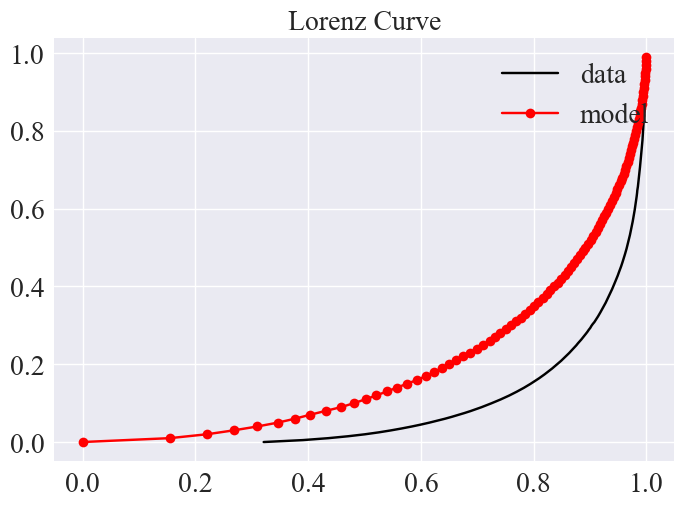

In [14]:
## lorenz curve 
plt.title('Lorenz Curve')
plt.plot(SCF_liq_dict['share_agents_ap'],
         SCF_liq_dict['share_ap'],
         'k-',
         label='data')
plt.plot(sim_moments['share_agents_ap'],
         sim_moments['share_ap'],
         'r-o',
         label='model')
plt.legend(loc=1)


Text(0, 0.5, 'Density')

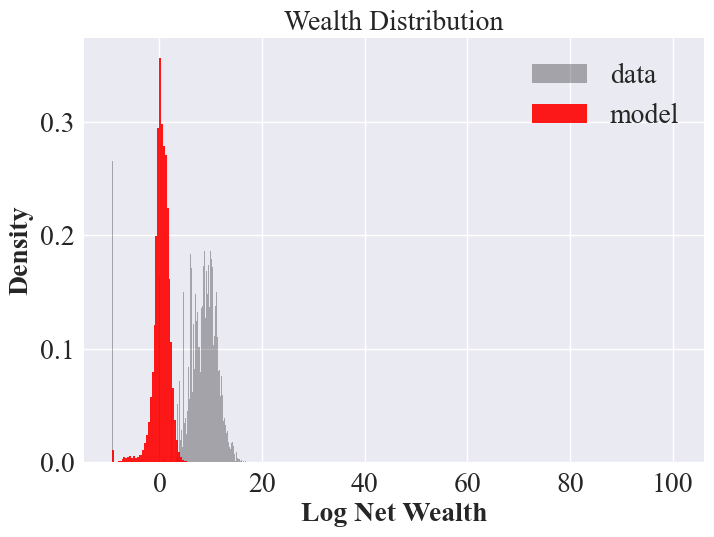

In [15]:

## wealth distribution

plt.title('Wealth Distribution')
n_SCF,bins_SCF,_ = plt.hist(np.log(SCF_lqwealth_sort+1e-4),
                             weights = SCF_lqweights_sort_norm,
                             density=True,
                             bins=300,
                            color='black',
                            alpha=0.3,
                           label='data')
n_model,bins_model,_ = plt.hist(np.log(sim_moments['ap_grid_dist']+1e-4),
                                weights = sim_moments['ap_pdfs_dist'],
                                 density=True,
                                bins=300,
                                alpha=0.9,
                                color='red',
                                label='model')
plt.legend(loc=0)
plt.xlabel('Log Net Wealth')
plt.ylabel('Density')


Text(0.5, 0, 'Working Age')

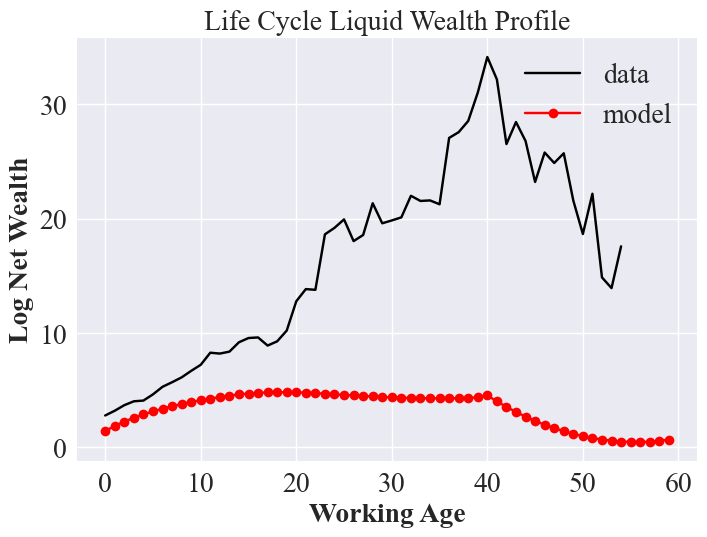

In [16]:

## life cycle
def simple_moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## life cycle pattern 
plt.title('Life Cycle Liquid Wealth Profile')
plt.plot(simple_moving_average(SCF_liq_dict['A_life'],6),
         'k-',
         label='data')
plt.plot(sim_moments['A_life'],
         'r-o',
         label='model')
plt.legend(loc=1)
plt.ylabel('Log Net Wealth')
plt.xlabel('Working Age')

### Objective function of indirect inference

In [17]:
def model_data_diff(model,
                    data_moments_dict,
                    moments_choice):
    
    ## get all the model moments 
    
    ## only get life cycle moments if needed 
    if any('life' in item for item in moments_choice):
        model_sim_moments = solve_and_simulate(model,life_cycle=True)
    else:
        model_sim_moments = solve_and_simulate(model,life_cycle=False)
    
    ## only calculate shares if included in the moment choices 
    
    if any('Top' in item for item in moments_choice):
        ## get wealth shares 
        wealth_share_moms = [mom for mom in moments_choice if 'Top' in mom]
        print('Shares:'+str(wealth_share_moms))

        top_shares = [float(mom.replace('Top ','')) for mom in moments_choice if 'Top' in mom]

        print('Shares:'+str(top_shares))
        ## to deal with wealth shares for given cut offs 
        for top_share in top_shares:
            wealth_share_this = wealth_share(model_sim_moments['ap_grid_dist'],
                                            model_sim_moments['ap_pdfs_dist'],
                                         top_agents_share = top_share)
            model_sim_moments['Top {}'.format(top_share)] = wealth_share_this

    ## calculate the moment-specific distances        
    distance_list = [np.array(data_moments_dict[mom])-np.array(model_sim_moments[mom]) for mom in moments_choice]

    # Initialize an empty list to store the flattened elements
    flattened_elements = []

    # Flatten the elements into the list
    for arr in distance_list:
        if arr.ndim == 0:  # Zero-dimensional (scalar) array
            flattened_elements.append(arr.item())
        else:
            flattened_elements.extend(arr)

    # Convert the list of flattened elements into a numpy array
    flattened_array = np.array(flattened_elements)
    
    ## calculate distance as a scalor
    distance = np.linalg.norm(flattened_array)
    
    return distance

In [18]:
def combine_moments(results_by_type):
    """
    input
    =====
    results_by_type: a list of dictioary storing all results by type
    
    output
    ======
    a dictionary storing results combining all types 
    
    """
    
    nb_types = len(results_by_type)
    probs = 1/nb_types 
    
    ## aggregate wealth 
    A_pe = np.sum(
        np.array([result['A'] 
                  for result in results_by_type])
    )*probs
    
    ## aggregate wealth 
    A_norm_pe = np.sum(
        np.array([result['A_norm'] 
                  for result in results_by_type])
    )*probs
    
    ## life cycle wealth
    A_life_pe = np.sum(np.array([result['A_life'] for result in results_by_type]),axis=0)*probs
    
    ## distribution 
    ap_grid_dist_pe = np.array([result['ap_grid_dist'] for result in results_by_type]).flatten()
    ap_pdfs_dist_pe = np.array([result['ap_pdfs_dist'] for result in results_by_type]).flatten()*probs
    ap_grid_dist_pe_sort = ap_grid_dist_pe.argsort()
    ap_grid_dist_pe = ap_grid_dist_pe[ap_grid_dist_pe_sort]
    ap_pdfs_dist_pe = ap_pdfs_dist_pe[ap_grid_dist_pe_sort]
    
    a_grid_dist_pe = np.array([result['a_grid_dist'] for result in results_by_type]).flatten()
    a_pdfs_dist_pe = np.array([result['a_pdfs_dist'] for result in results_by_type]).flatten()*probs
    a_grid_dist_pe_sort = a_grid_dist_pe.argsort()
    a_grid_dist_pe = a_grid_dist_pe[a_grid_dist_pe_sort]
    a_pdfs_dist_pe = a_pdfs_dist_pe[a_grid_dist_pe_sort]
    

    ## lorenz share
    share_agents_ap_pe,share_ap_pe = Lorenz(results_by_type)
    
    ## gini
    gini_this_pe = gini(share_agents_ap_pe,
                        share_ap_pe)


    model_dct_pe =  {'A':A_pe,
                     'A_norm':A_norm_pe,
                  'A_life': A_life_pe,
                  'share_agents_ap':share_agents_ap_pe,
                  'share_ap':share_ap_pe,
                  'ap_grid_dist':ap_grid_dist_pe,
                  'ap_pdfs_dist':ap_pdfs_dist_pe,
                   'a_grid_dist':a_grid_dist_pe,
                   'a_pdfs_dist':a_pdfs_dist_pe,
                  'gini':gini_this_pe,
                   }
    
    return model_dct_pe

def models_data_diff(model_list,
                    data_moments_dict,
                    moments_choice):
    if len(model_list)==1:
        model_sim_moments = solve_and_simulate(model)
    else:
        sim_moments_list = [] 
        #HH_blocks_list = []
        for i,model in model_list:
            sim_moments_this = solve_and_simulate(model)
            sim_moments_list.append(sim_moments_this)
            #HH_blocks_list.append(sim_HH_block_this)
            
        ## combine moments of different types 
        model_sim_moments = combine_moments(sim_moments_list)
    
    ## the rest is the same regardless of one type or multiple types 
    ## get wealth shares 
    wealth_share_moms = [mom for mom in moments_choice if 'Top' in mom]
    print('Shares:'+str(wealth_share_moms))

    top_shares = [float(mom.replace('Top ','')) for mom in moments_choice if 'Top' in mom]
    
    print('Shares:'+str(top_shares))
    ## to deal with wealth shares for given cut offs 
    for top_share in top_shares:
        wealth_share_this = wealth_share(model_sim_moments['ap_grid_dist'],
                                        model_sim_moments['ap_pdfs_dist'],
                                     top_agents_share = top_share)
        model_sim_moments['Top {}'.format(top_share)] = wealth_share_this
        
        
    distance_list = [np.array(data_moments_dict[mom])-np.array(model_sim_moments[mom]) for mom in moments_choice]

    # Initialize an empty list to store the flattened elements
    flattened_elements = []

    # Flatten the elements into the list
    for arr in distance_list:
        if arr.ndim == 0:  # Zero-dimensional (scalar) array
            flattened_elements.append(arr.item())
        else:
            flattened_elements.extend(arr)

    # Convert the list of flattened elements into a numpy array
    flattened_array = np.array(flattened_elements)
    
    ## calculate distance as a scalor
    distance = np.linalg.norm(flattened_array)
    return distance

In [19]:
## create some fake data moments for experiments 

moments_choice = ['A_norm',
                  #'Top 0.3',
                  #'Top 0.5',
                  #'Top 0.8',
                  #'gini'
                 #'A_life'
                 ]

#distance_SCF = model_data_diff(lc_mkv,
#                               SCF_liq_dict,
#                               moments_choice)

#print('The moment distance between model and data is '+str(distance_SCF))

In [20]:
print('SCF moments: '+str(SCF_liq_dict['A_norm']))
print('Model simulated moments: '+str(sim_moments['A_norm']))

SCF moments: 0.6662500975349421
Model simulated moments: 1.2888704059881158


In [21]:
def ParaEst(ObjSpec,
            para_guess,
            method = 'Nelder-Mead',
            bounds = None,
            jac = None,
            options = {'disp': True,
                      'maxiter': 1500}):
    """
    an estimating function that minimizes OjbSpec function that gives parameter estimates
    """
    print('Started the estimation...')
    t_start = time()

    results = minimize(ObjSpec,
                         x0 = para_guess,
                         method = method,
                         bounds = bounds,
                         jac = jac,
                         options = options)
    if results['success']==True:
        parameter = results['x']
    else:
        #parameter = np.array([])
        parameter = np.nan
        
    t_finish = time()
    print('Finished the estimation')
    print("Time taken, in seconds: "+ str(t_finish - t_start))
    return parameter 

### Test 1. Estimating mean $\beta$ to fit average wealth to permanent income ratio 

In [ ]:
def objective_est_beta_point(β):
    lc_mkv.β = β
    return model_data_diff(lc_mkv,
                           SCF_liq_dict,
                           moments_choice)

## estimate the parameter 
β_mean_est = ParaEst(objective_est_beta_point,
       np.array([0.98]),
       method = 'trust-constr',
       bounds = ((0.9,0.99),)
       )
print('The average $\beta$ estimated to match mean wealth/income ratio in SCF is'+ str(β_mean_est))

Started the estimation...
Solve the model...
Simulate the model...
time taken to get SS dist:7.820694208145142
memory usage: 0.5027389526367188
No life cycle profile is generated
Time taken, in seconds: 10.767030000686646
Solve the model...
Simulate the model...
time taken to get SS dist:7.834356069564819
memory usage: 0.5006179809570312
No life cycle profile is generated
Time taken, in seconds: 10.782317161560059
Solve the model...
Simulate the model...
time taken to get SS dist:7.900464773178101
memory usage: 0.5006217956542969
No life cycle profile is generated
Time taken, in seconds: 10.875502109527588
Solve the model...
Simulate the model...
time taken to get SS dist:7.769420146942139
memory usage: 0.50079345703125
No life cycle profile is generated
Time taken, in seconds: 11.491665124893188
Solve the model...
Simulate the model...
time taken to get SS dist:8.174925088882446
memory usage: 0.480621337890625
No life cycle profile is generated
Time taken, in seconds: 11.1777789592742

Simulate the model...
time taken to get SS dist:7.9463958740234375
memory usage: 0.4524383544921875
No life cycle profile is generated
Time taken, in seconds: 10.989439010620117
Solve the model...
Simulate the model...
time taken to get SS dist:8.624024629592896
memory usage: 0.45142364501953125
No life cycle profile is generated
Time taken, in seconds: 12.47867202758789
Solve the model...
Simulate the model...
time taken to get SS dist:8.220226049423218
memory usage: 0.4348945617675781
No life cycle profile is generated
Time taken, in seconds: 11.249151945114136
Solve the model...
Simulate the model...
time taken to get SS dist:7.930223226547241
memory usage: 0.4373207092285156
No life cycle profile is generated
Time taken, in seconds: 11.725476026535034
Solve the model...
Simulate the model...
time taken to get SS dist:8.010576725006104
memory usage: 0.43609619140625
No life cycle profile is generated
Time taken, in seconds: 11.006309747695923
Solve the model...
Simulate the model...

Simulate the model...
time taken to get SS dist:7.7827839851379395
memory usage: 0.4344482421875
No life cycle profile is generated
Time taken, in seconds: 10.770251035690308
Solve the model...
Simulate the model...
time taken to get SS dist:7.746066093444824
memory usage: 0.4338035583496094
No life cycle profile is generated
Time taken, in seconds: 11.498836040496826
Solve the model...
Simulate the model...
time taken to get SS dist:7.960673093795776
memory usage: 0.4351463317871094
No life cycle profile is generated
Time taken, in seconds: 10.986601829528809
Solve the model...
Simulate the model...
time taken to get SS dist:8.230255842208862
memory usage: 0.43526458740234375
No life cycle profile is generated
Time taken, in seconds: 12.027656078338623
Solve the model...
Simulate the model...
time taken to get SS dist:8.021241903305054
memory usage: 0.4356575012207031
No life cycle profile is generated
Time taken, in seconds: 11.201436758041382
Solve the model...
Simulate the model...

Simulate the model...
time taken to get SS dist:7.842015981674194
memory usage: 0.43316650390625
No life cycle profile is generated
Time taken, in seconds: 10.845937967300415
Solve the model...
Simulate the model...
time taken to get SS dist:7.766138315200806
memory usage: 0.4341011047363281
No life cycle profile is generated
Time taken, in seconds: 11.543712139129639
Solve the model...
Simulate the model...
time taken to get SS dist:8.282099962234497
memory usage: 0.4341888427734375
No life cycle profile is generated
Time taken, in seconds: 11.39636492729187
Solve the model...
Simulate the model...
time taken to get SS dist:7.779790878295898
memory usage: 0.4341278076171875
No life cycle profile is generated
Time taken, in seconds: 11.543859004974365
Solve the model...
Simulate the model...
time taken to get SS dist:7.860472202301025
memory usage: 0.43488311767578125
No life cycle profile is generated
Time taken, in seconds: 10.849568843841553
Solve the model...
Simulate the model...


Simulate the model...
time taken to get SS dist:7.772381067276001
memory usage: 0.4349555969238281
No life cycle profile is generated
Time taken, in seconds: 10.766319751739502
Solve the model...
Simulate the model...
time taken to get SS dist:7.784921169281006
memory usage: 0.4347381591796875
No life cycle profile is generated
Time taken, in seconds: 11.588392972946167
Solve the model...
Simulate the model...
time taken to get SS dist:7.86441707611084
memory usage: 0.43468475341796875
No life cycle profile is generated
Time taken, in seconds: 10.850112915039062
Solve the model...
Simulate the model...
time taken to get SS dist:7.80915093421936
memory usage: 0.4356842041015625
No life cycle profile is generated
Time taken, in seconds: 11.56316614151001
Solve the model...
Simulate the model...
time taken to get SS dist:8.074144840240479
memory usage: 0.4341773986816406
No life cycle profile is generated
Time taken, in seconds: 11.065606355667114
Solve the model...
Simulate the model...


Simulate the model...
time taken to get SS dist:8.191028833389282
memory usage: 0.43392181396484375
No life cycle profile is generated
Time taken, in seconds: 11.212725162506104
Solve the model...
Simulate the model...
time taken to get SS dist:7.816067934036255
memory usage: 0.4344520568847656
No life cycle profile is generated
Time taken, in seconds: 10.807693243026733
Solve the model...
Simulate the model...
time taken to get SS dist:7.772740840911865
memory usage: 0.4330558776855469
No life cycle profile is generated
Time taken, in seconds: 10.776765823364258
Solve the model...
Simulate the model...
time taken to get SS dist:7.804553985595703
memory usage: 0.43381500244140625
No life cycle profile is generated
Time taken, in seconds: 11.55151104927063
Solve the model...
Simulate the model...
time taken to get SS dist:7.776907682418823
memory usage: 0.4343757629394531
No life cycle profile is generated
Time taken, in seconds: 10.768611907958984
Solve the model...
Simulate the model.

Simulate the model...
time taken to get SS dist:8.015971899032593
memory usage: 0.43300628662109375
No life cycle profile is generated
Time taken, in seconds: 11.045392990112305
Solve the model...
Simulate the model...
time taken to get SS dist:7.988154888153076
memory usage: 0.4317131042480469
No life cycle profile is generated
Time taken, in seconds: 11.74509882926941
Solve the model...
Simulate the model...
time taken to get SS dist:7.818581819534302
memory usage: 0.4315528869628906
No life cycle profile is generated
Time taken, in seconds: 10.806871891021729
Solve the model...
Simulate the model...
time taken to get SS dist:7.792649984359741
memory usage: 0.4311637878417969
No life cycle profile is generated
Time taken, in seconds: 11.542641878128052
Solve the model...
Simulate the model...
time taken to get SS dist:7.775766134262085
memory usage: 0.4315376281738281
No life cycle profile is generated
Time taken, in seconds: 10.779521942138672
Solve the model...
Simulate the model..

Simulate the model...
time taken to get SS dist:7.807984113693237
memory usage: 0.4329643249511719
No life cycle profile is generated
Time taken, in seconds: 10.831881999969482
Solve the model...
Simulate the model...
time taken to get SS dist:7.901676177978516
memory usage: 0.4341468811035156
No life cycle profile is generated
Time taken, in seconds: 11.692496061325073
Solve the model...
Simulate the model...
time taken to get SS dist:7.990872144699097
memory usage: 0.4312400817871094
No life cycle profile is generated
Time taken, in seconds: 10.987869024276733
Solve the model...
Simulate the model...
time taken to get SS dist:7.858890056610107
memory usage: 0.431915283203125
No life cycle profile is generated
Time taken, in seconds: 11.597604990005493
Solve the model...
Simulate the model...
time taken to get SS dist:7.7731640338897705
memory usage: 0.43218994140625
No life cycle profile is generated
Time taken, in seconds: 10.764264822006226
Solve the model...
Simulate the model...


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Simulate the model...
time taken to get SS dist:8.026730060577393
memory usage: 0.4311943054199219
No life cycle profile is generated
Time taken, in seconds: 11.022302150726318
Solve the model...
Simulate the model...
time taken to get SS dist:7.8416969776153564
memory usage: 0.4310188293457031
No life cycle profile is generated
Time taken, in seconds: 11.58621096611023
Solve the model...
Simulate the model...
time taken to get SS dist:7.8359129428863525
memory usage: 0.4327659606933594
No life cycle profile is generated
Time taken, in seconds: 10.830111980438232
Solve the model...
Simulate the model...
time taken to get SS dist:7.8544628620147705
memory usage: 0.43408203125
No life cycle profile is generated
Time taken, in seconds: 11.721044063568115
Solve the model...
Simulate the model...
time taken to get SS dist:7.974579095840454
memory usage: 0.43286895751953125
No life cycle profile is generated
Time taken, in seconds: 10.972119092941284
Solve the model...
Simulate the model...


Simulate the model...
time taken to get SS dist:7.487519979476929
memory usage: 0.43335723876953125
No life cycle profile is generated
Time taken, in seconds: 10.485020160675049
Solve the model...
Simulate the model...
time taken to get SS dist:7.64200496673584
memory usage: 0.43289947509765625
No life cycle profile is generated
Time taken, in seconds: 11.388648986816406
Solve the model...
Simulate the model...
time taken to get SS dist:7.571367979049683
memory usage: 0.4332466125488281
No life cycle profile is generated
Time taken, in seconds: 10.55798888206482
Solve the model...
Simulate the model...
time taken to get SS dist:7.489526033401489
memory usage: 0.4327659606933594
No life cycle profile is generated
Time taken, in seconds: 11.237704992294312
Solve the model...
Simulate the model...
time taken to get SS dist:7.5392677783966064
memory usage: 0.43194580078125
No life cycle profile is generated
Time taken, in seconds: 10.52772307395935
Solve the model...
Simulate the model...


### Test 2. Estimating mean risk aversion $\rho$ to fit life-cycle wealth profile

In [29]:
### objective funcitons for different parameters 
moments_choice = ['A_life']

def objective_est_rho_point(ρ):
    lc_mkv.ρ = ρ
    return model_data_diff(lc_mkv,
                           SCF_liq_dict,
                           moments_choice)

## estimate the parameter 
ρ_mean_est = ParaEst(objective_est_rho_point,
                   np.array([2.0]),
                   method = 'trust-constr',
                   bounds = ((0.9,3.0),)
                   )
print('The average $\rho$ estimated to match life-cycle liquid wealth profile in SCF is'+ str(ρ_mean_est))

Solve the model...
Simulate the model...
time taken to get SS dist:9.413068771362305
memory usage: 0.45473480224609375
Time taken, in seconds: 12.356200933456421
Solve the model...
Simulate the model...
time taken to get SS dist:9.501926183700562
memory usage: 0.4537239074707031
Time taken, in seconds: 12.359914064407349
Solve the model...
Simulate the model...
time taken to get SS dist:9.529915809631348
memory usage: 0.45398712158203125
Time taken, in seconds: 12.393582820892334
Solve the model...
Simulate the model...
time taken to get SS dist:9.368290901184082
memory usage: 0.45432281494140625
Time taken, in seconds: 12.238111972808838
Solve the model...
Simulate the model...
time taken to get SS dist:9.372731924057007
memory usage: 0.4545249938964844
Time taken, in seconds: 12.221732139587402
Solve the model...
Simulate the model...
time taken to get SS dist:9.484250783920288
memory usage: 0.4550514221191406
Time taken, in seconds: 12.343342065811157
Solve the model...
Simulate the

### Test 3 jointly estimating $\beta$ and $\rho$ to match mean wealth and life cycle wealth

In [22]:
moments_choice = ['A_life']

def objective_est_rho_beta_point(paras):
    lc_mkv.β,lc_mkv.ρ = paras
    return model_data_diff(lc_mkv,
                           SCF_liq_dict,
                           moments_choice)



## estimate the parameter 
β_mean_est_joint, ρ_mean_est_joint= ParaEst(objective_est_rho_beta_point,
                                   np.array([0.92,2.3]),
                                   method = 'trust-constr',
                                   bounds = ((0.9,0.99),(0.9,3.0),)
                                   )
print('The average $\beta$ and $\rho$ estimated to match life-cycle liquid wealth profile in SCF are '+ str(β_mean_est_joint) +', '+str(ρ_mean_est_joint))

Started the estimation...
Solve the model...
Simulate the model...
time taken to get SS dist:7.810979843139648
memory usage: 0.4988517761230469
Time taken, in seconds: 10.704876899719238
Solve the model...
Simulate the model...
time taken to get SS dist:7.882143020629883
memory usage: 0.49957275390625
Time taken, in seconds: 10.781030893325806
Solve the model...
Simulate the model...
time taken to get SS dist:7.841084957122803
memory usage: 0.4972801208496094
Time taken, in seconds: 10.749675035476685
Solve the model...
Simulate the model...
time taken to get SS dist:7.807862043380737
memory usage: 0.49500274658203125
Time taken, in seconds: 10.683526039123535
Solve the model...
Simulate the model...
time taken to get SS dist:7.7866151332855225
memory usage: 0.4990577697753906
Time taken, in seconds: 10.68807578086853
Solve the model...
Simulate the model...
time taken to get SS dist:7.671233177185059
memory usage: 0.4953651428222656
Time taken, in seconds: 10.556334972381592
Solve the

Simulate the model...
time taken to get SS dist:7.721014022827148
memory usage: 0.4947853088378906
Time taken, in seconds: 10.622565746307373
Solve the model...
Simulate the model...
time taken to get SS dist:7.7344019412994385
memory usage: 0.49416351318359375
Time taken, in seconds: 10.632719993591309
Solve the model...
Simulate the model...
time taken to get SS dist:7.7593889236450195
memory usage: 0.4954643249511719
Time taken, in seconds: 10.665476083755493
Solve the model...
Simulate the model...
time taken to get SS dist:7.76112174987793
memory usage: 0.4943504333496094
Time taken, in seconds: 10.66008710861206
Solve the model...
Simulate the model...
time taken to get SS dist:7.729640960693359
memory usage: 0.49538421630859375
Time taken, in seconds: 10.634721994400024
Solve the model...
Simulate the model...
time taken to get SS dist:7.785977125167847
memory usage: 0.49492645263671875
Time taken, in seconds: 10.684974193572998
Solve the model...
Simulate the model...
time take

Simulate the model...
time taken to get SS dist:7.817668676376343
memory usage: 0.49083709716796875
Time taken, in seconds: 10.715903997421265
Solve the model...
Simulate the model...
time taken to get SS dist:7.7609946727752686
memory usage: 0.4911003112792969
Time taken, in seconds: 10.664648294448853
Solve the model...
Simulate the model...
time taken to get SS dist:7.746504306793213
memory usage: 0.49149322509765625
Time taken, in seconds: 10.65459394454956
Solve the model...
Simulate the model...
time taken to get SS dist:7.590582847595215
memory usage: 0.492340087890625
Time taken, in seconds: 10.505380868911743
Solve the model...
Simulate the model...
time taken to get SS dist:7.8233301639556885
memory usage: 0.4918365478515625
Time taken, in seconds: 10.722541809082031
Solve the model...
Simulate the model...
time taken to get SS dist:7.7299418449401855
memory usage: 0.4914207458496094
Time taken, in seconds: 10.628440141677856
Solve the model...
Simulate the model...
time take

Simulate the model...
time taken to get SS dist:7.786596059799194
memory usage: 0.43489837646484375
Time taken, in seconds: 10.700762748718262
Solve the model...
Simulate the model...
time taken to get SS dist:7.690715074539185
memory usage: 0.43399810791015625
Time taken, in seconds: 10.608550310134888
Solve the model...
Simulate the model...
time taken to get SS dist:7.703402042388916
memory usage: 0.434356689453125
Time taken, in seconds: 10.688926935195923
Solve the model...
Simulate the model...
time taken to get SS dist:7.91858696937561
memory usage: 0.4350624084472656
Time taken, in seconds: 11.180947065353394
Solve the model...
Simulate the model...
time taken to get SS dist:7.86991286277771
memory usage: 0.434417724609375
Time taken, in seconds: 10.877315044403076
Solve the model...
Simulate the model...
time taken to get SS dist:7.875953912734985
memory usage: 0.43546295166015625
Time taken, in seconds: 10.7967848777771
Solve the model...
Simulate the model...
time taken to g

Simulate the model...
time taken to get SS dist:7.791244029998779
memory usage: 0.4344978332519531
Time taken, in seconds: 10.68693494796753
Solve the model...
Simulate the model...
time taken to get SS dist:7.788910150527954
memory usage: 0.4347496032714844
Time taken, in seconds: 10.68140697479248
Solve the model...
Simulate the model...
time taken to get SS dist:7.800971984863281
memory usage: 0.4344215393066406
Time taken, in seconds: 10.705773115158081
`xtol` termination condition is satisfied.
Number of iterations: 87, function evaluations: 207, CG iterations: 96, optimality: 1.09e-05, constraint violation: 0.00e+00, execution time: 2.2e+03 s.
Finished the estimation
Time taken, in seconds: 2216.401508808136
ho$ estimated to match life-cycle liquid wealth profile in SCF are 0.9899999975061986, 2.2356019196960597


### resimulate the model to get the moments based on the estimated parameter value

In [25]:
## resolve and resimulate the model

#set the grid to be finner 

n_m = 50
n_p = 50

sim_moments_est_paras = solve_and_simulate(lc_mkv,
                                           life_cycle = True)

Solve the model...
Simulate the model...
time taken to get SS dist:7.8399810791015625
memory usage: 0.43524932861328125
Time taken, in seconds: 10.790004014968872


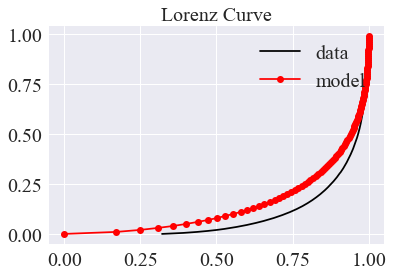

In [26]:
## lorenz curve 
plt.title('Lorenz Curve')
plt.plot(SCF_liq_dict['share_agents_ap'],
         SCF_liq_dict['share_ap'],
         'k-',
         label='data')
plt.plot(sim_moments['share_agents_ap'],
         sim_moments['share_ap'],
         'r-o',
         label='model')
plt.legend(loc=1)

Text(0, 0.5, 'Density')

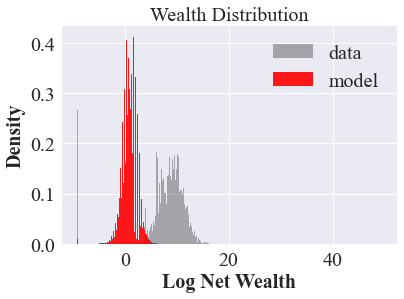

In [27]:
## wealth distribution

plt.title('Wealth Distribution')
n_SCF,bins_SCF,_ = plt.hist(np.log(SCF_lqwealth_sort+1e-4),
                             weights = SCF_lqweights_sort_norm,
                             density=True,
                             bins=300,
                            color='black',
                            alpha=0.3,
                           label='data')
n_model,bins_model,_ = plt.hist(np.log(sim_moments['ap_grid_dist']+1e-4),
                                weights = sim_moments['ap_pdfs_dist'],
                                 density=True,
                                bins=300,
                                alpha=0.9,
                                color='red',
                                label='model')
plt.legend(loc=0)
plt.xlabel('Log Net Wealth')
plt.ylabel('Density')

Text(0.5, 0, 'Working Age')

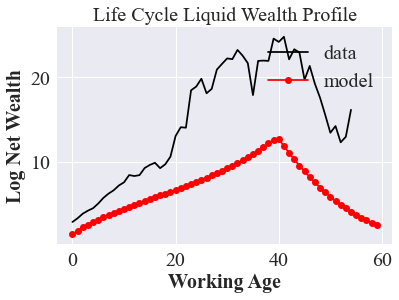

In [28]:
## life cycle
def simple_moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## life cycle pattern 
plt.title('Life Cycle Liquid Wealth Profile')
plt.plot(simple_moving_average(SCF_liq_dict['A_life'],6),
         'k-',
         label='data')
plt.plot(sim_moments['A_life'],
         'r-o',
         label='model')
plt.legend(loc=1)
plt.ylabel('Log Net Wealth')
plt.xlabel('Working Age')